In [1]:
using CSV, Plots, Random, LinearAlgebra, Statistics, DataFrames, ARFIMA, GLM, RDatasets, XGBoost, SparseArrays
include("proxgrad.jl")

proxgrad_const

In [2]:
sentiment = CSV.read("sentiment4.csv")
sentiment = [sentiment[1:6] sentiment[8]]

Zoom = CSV.read("ZM_adjclose.csv")[["Price","Stock Splits"]]
Facebook = CSV.read("FB_adjclose.csv")[["Price","Stock Splits"]]
Amazon = CSV.read("AMZN_adjclose.csv")[["Price","Stock Splits"]]
Cisco = CSV.read("CSCO_adjclose.csv")[["Price","Stock Splits"]]
Netflix = CSV.read("NFLX_adjclose.csv")[["Price","Stock Splits"]]
Intel = CSV.read("INTC_adjclose.csv")[["Price","Stock Splits"]]
Tesla = CSV.read("TSLA_adjclose.csv")[["Price","Stock Splits"]]
Alibaba = CSV.read("BABA_adjclose.csv")[["Price","Stock Splits"]]
Microsoft = CSV.read("MSFT_adjclose.csv")[["Price","Stock Splits"]]
Nvidia = CSV.read("NVDA_adjclose.csv")[["Price","Stock Splits"]];

In [3]:
function standardize(stock)
    return (stock .- mean(stock))/sqrt(var(stock))
end

function MA(stock)
    ma = stock[1:4]
    for i in 5:length(stock)
        ma = vcat(ma, mean(stock[i-4:i]))
    end
    return ma
end

function abs_err(y,pred)
    return mean(abs.(y-pred))/mean(y)
end

abs_err (generic function with 1 method)

In [4]:
sentiment[1] = standardize(sentiment[1])
sentiment[2] = standardize(sentiment[2])
sentiment[3] = standardize(sentiment[3])
sentiment[4] = standardize(sentiment[4])
sentiment[5] = standardize(sentiment[5])
sentiment[6] = standardize(sentiment[6])
sentiment[7] = standardize(sentiment[7])

Zoom[1] = standardize(Zoom[1])
Facebook[1] = standardize(Facebook[1])
Amazon[1] = standardize(Amazon[1])
Cisco[1] = standardize(Cisco[1])
Netflix[1] = standardize(Netflix[1])
Intel[1] = standardize(Intel[1])
Tesla[1] = standardize(Tesla[1])
Alibaba[1] = standardize(Alibaba[1])
Microsoft[1] = standardize(Microsoft[1])
Nvidia[1] = standardize(Nvidia[1])

Zoom_MA = MA(Zoom[1])
Facebook_MA = MA(Facebook[1])
Amazon_MA = MA(Amazon[1])
Cisco_MA = MA(Cisco[1])
Netflix_MA = MA(Netflix[1])
Intel_MA = MA(Intel[1])
Tesla_MA = MA(Tesla[1])
Alibaba_MA = MA(Alibaba[1])
Microsoft_MA = MA(Microsoft[1])
Nvidia_MA = MA(Nvidia[1]);

In [5]:
function select_best_model(stock, sentiment)
    # index for 5-fold
    split = [43, 43+44, 43+44*2, 43+44*3, 43+44*4, 43+44*5]
    num_of_model = 3
    mse = zeros(num_of_model,5)
    w = zeros(18)
    for i in 1:5
        w_set = []
        # setting train and validation set
        split_cur = split[i]
        split2 = Int(round(split_cur*4/5))

        stock_train = stock[1][1:split2]
        stock_val = stock[1][split2 + 1:split_cur]
        
        splits_train = stock[2][1:split2]
        splits_val = stock[2][split2 + 1:split_cur]

        sent_train = sentiment[1][1:split2]
        sent_val = sentiment[1][split2 + 1:split_cur]

        death_train = sentiment[3][1:split2]
        death_val = sentiment[3][split2 + 1:split_cur]

        vac_train = sentiment[2][1:split2]
        vac_val = sentiment[2][split2 + 1:split_cur]

        shut_train = sentiment[4][1:split2]
        shut_val = sentiment[4][split2 + 1:split_cur]

        # Naive Model, w[1:5]
        Xtrain = [sent_train death_train vac_train shut_train ones(length(sent_train))]
        Xval = [sent_val death_val vac_val shut_val ones(length(sent_val))]
        Ytrain = stock_train
        Yval = stock_val

        w_cur = Xtrain\Ytrain
        w_set = vcat(w_set, w_cur)
        pred = Xval*w_cur
        mse[1,i] = abs_err(Yval,pred)

        # AR1 Model, w[6:11]
        Xtrain = [sent_train[2:end] stock_train[1:end-1] death_train[2:end] vac_train[2:end] shut_train[2:end] splits_train[2:end] ones(length(sent_train)-1)]
        Xval = [sent_val[2:end] stock_val[1:end-1] death_val[2:end] vac_val[2:end] shut_val[2:end] splits_val[2:end] ones(length(sent_val)-1)]
        Ytrain = stock_train[2:end]
        Yval = stock_val[2:end]

        w_cur = Xtrain\Ytrain
        w_set = vcat(w_set, w_cur)
        pred = Xval*w_cur
        mse[2,i] = abs_err(Yval,pred)

        # AR2 Model, w[12:18]
        Xtrain = [sent_train[3:end] stock_train[2:end-1] stock_train[1:end-2] death_train[3:end] vac_train[3:end] shut_train[3:end] splits_train[3:end] ones(length(sent_train)-2)]
        Xval = [sent_val[3:end] stock_val[2:end-1] stock_val[1:end-2] death_val[3:end] vac_val[3:end] shut_val[3:end] splits_val[3:end] ones(length(sent_val)-2)]
        Ytrain = stock_train[3:end]
        Yval = stock_val[3:end]

        w_cur = Xtrain\Ytrain
        w_set = vcat(w_set, w_cur)
        pred = Xval*w_cur
        mse[3,i] = abs_err(Yval,pred)
        w = hcat(w,w_set)
    end
    w = w[:,2:6]
    
    avg_mse = mean(mse, dims=2)
    final_model = findmin(avg_mse)[2][1]
    test_mse = zeros(5)
    model = ["Naive Model", "AR1 Model", "AR2 Model"]
    model_length = [5, 6, 7]
    fig = plot(linestyle = :dot, title = "Test Predictions from 9/17 to 10/30")
    w_test = zeros(model_length[final_model])
    
    for i in 1:5
        #Fixed index
        stock_train = stock[1][1:split[i]]
        splits_train = stock[2][1:split[i]]
        sent_train = sentiment[1][1:split[i]]
        death_train = sentiment[3][1:split[i]]
        vac_train = sentiment[2][1:split[i]]
        shut_train = sentiment[4][1:split[i]]

        stock_test = stock[1][split[i]+1:split[i+1]]
        splits_test = stock[2][split[i]+1:split[i+1]]
        sent_test = sentiment[1][split[i]+1:split[i+1]]
        death_test = sentiment[3][split[i]+1:split[i+1]]
        vac_test = sentiment[2][split[i]+1:split[i+1]]
        shut_test = sentiment[4][split[i]+1:split[i+1]]

        if final_model == 1   # Naive Model
            Xtrain = [sent_train death_train vac_train shut_train splits_train ones(length(sent_train))]
            Xtest = [sent_test death_test vac_test shut_test splits_test ones(length(sent_test))]
            Ytrain = stock_train
            Ytest = stock_test

            w_cur = Xtrain\Ytrain
            w_test = hcat(w_test, w_cur)
            pred = Xtest*w_cur
            test_mse[i] = abs_err(Ytest,pred)
            #plot
            if i == 5
                date = [1:44]
                plot!(date, Ytest, color = :red,  label = "Actual Stock Price")
                plot!(date, pred, color = :blue, label = "Naive Model")
            end

        elseif final_model == 2   # AR1 Model
            Xtrain = [sent_train[2:end] stock_train[1:end-1] death_train[2:end] vac_train[2:end] shut_train[2:end] splits_train[2:end] ones(length(stock_train)-1)]
            Xtest = [sent_test[2:end] stock_test[1:end-1] death_test[2:end] vac_test[2:end] shut_test[2:end] splits_test[2:end] ones(length(stock_test)-1)]
            Ytrain = stock_train[2:end]
            Ytest = stock_test[2:end]

            w_cur = Xtrain\Ytrain
            w_test = hcat(w_test, w_cur)
            pred = Xtest*w_cur
            test_mse[i] = abs_err(Ytest,pred)
            #plot
            if i == 5
                date = [2:44]
                plot!(date, Ytest, color = :red,  label = "Actual Stock Price")
                plot!(date, pred, color = :blue, label = "AR1 Model")
            end

        elseif final_model == 3   # AR2 Model
            Xtrain = [sent_train[3:end] stock_train[2:end-1] stock_train[1:end-2] death_train[3:end] vac_train[3:end] shut_train[3:end] splits_train[3:end] ones(length(sent_train)-2)]
            Xtest = [sent_test[3:end] stock_test[2:end-1] stock_test[1:end-2] death_test[3:end] vac_test[3:end] shut_test[3:end] splits_test[3:end] ones(length(stock_test)-2)]
            Ytrain = stock_train[3:end]
            Ytest = stock_test[3:end]

            w_cur = Xtrain\Ytrain
            w_test = hcat(w_test, w_cur)
            pred = Xtest*w_cur
            test_mse[i] = abs_err(Ytest,pred) 
            #plot
            if i == 5
                date = [3:44]
                plot!(date, Ytest, color = :red, label = "Actual Stock Price")
                plot!(date, pred, color = :blue, label = "AR2 Model")
            end
        else
            print("error")
        end  
    end
    w_test = w_test[:,2:6]
    display(fig)
    print("Selected Model: ", model[final_model], "\nEstimated Error: ", mean(test_mse), "\nValidation Error: ", findmin(avg_mse)[1])
end

select_best_model (generic function with 1 method)

In [6]:
function select_best_model_1(stock, sentiment, stockMa)
    # index for 5-fold
    split = [43, 43+44, 43+44*2, 43+44*3, 43+44*4, 43+44*5]
    num_of_model = 2
    mse = zeros(num_of_model*9,5)
    w = zeros(180)
    for i in 1:5
        w_set = []
        position = 1
        # setting train and validation set
        split_cur = split[i]
        split2 = Int(round(split_cur*4/5))

        stock_train = stock[1][1:split2]
        stock_val = stock[1][split2 + 1:split_cur]
        
        splits_train = stock[2][1:split2]
        splits_val = stock[2][split2 + 1:split_cur]
        
        stockMa_train = stockMa[1:split2]
        stockMa_val = stockMa[split2 + 1:split_cur]

        sent_train = sentiment[1][1:split2]
        sent_val = sentiment[1][split2 + 1:split_cur]

        death_train = sentiment[3][1:split2]
        death_val = sentiment[3][split2 + 1:split_cur]

        vac_train = sentiment[2][1:split2]
        vac_val = sentiment[2][split2 + 1:split_cur]

        shut_train = sentiment[4][1:split2]
        shut_val = sentiment[4][split2 + 1:split_cur]
        
        spred_train = sentiment[5][1:split2]
        spred_val = sentiment[5][split2 + 1:split_cur]
        
        death_train = sentiment[6][1:split2]
        death_val = sentiment[6][split2 + 1:split_cur]
        
        pos_train = sentiment[7][1:split2]
        pos_val = sentiment[7][split2 + 1:split_cur]

        #Naive Model, w[1:9]*9
        Xtrain = [sent_train[2:end] stockMa_train[1:end-1] death_train[2:end] vac_train[2:end] shut_train[2:end] spred_train[2:end] death_train[2:end] pos_train[2:end] splits_train[2:end] ones(length(sent_train)-1)]
        Xval = [sent_val[2:end] stockMa_val[1:end-1] death_val[2:end] vac_val[2:end] shut_val[2:end] spred_val[2:end] death_val[2:end] pos_val[2:end] splits_val[2:end] ones(length(sent_val)-1)]
        Ytrain = stock_train[2:end]
        Yval = stock_val[2:end]
        
        for j in [0.1:0.1:0.9;]
            n = length(Ytrain)
            loss = 1/n*QuadLoss()

            # we form λ|| ⋅ ||^2 by multiplying the QuadReg() function by λ
            λ = j
            reg = λ*QuadReg()

            w_cur = proxgrad(loss, reg, Xtrain, Ytrain, maxiters=1000)
            w_set = vcat(w_set, w_cur)
            pred = Xval*w_cur

            mse[position,i] = abs_err(Yval,pred)
            position = position + 1
        end

        for j in [0.1:0.1:0.9;]
            n = length(Ytrain)
            loss = 1/n*QuadLoss()

            # we form λ|| ⋅ ||^2 by multiplying the QuadReg() function by λ
            λ = j
            reg = λ*OneReg()

            w_cur = proxgrad(loss, reg, Xtrain, Ytrain, maxiters=1000)
            w_set = vcat(w_set, w_cur)
            pred = Xval*w_cur

            mse[position,i] = abs_err(Yval,pred)
            position = position + 1
        end
        w = hcat(w, w_set)
    end
    return w,mse
end

select_best_model_1 (generic function with 1 method)

In [7]:
function select_best_model_2(stock, sentiment, w, mse, stockMa)
    split = [43, 43+44, 43+44*2, 43+44*3, 43+44*4, 43+44*5]
    avg_mse = mean(mse, dims=2)
    final_model = findmin(avg_mse)[2][1]
    test_mse = zeros(5)
    fig = plot(linestyle = :dot, title = "Test Predictions from 9/17 to 10/30")
    w_test = zeros(10)
        
    for i in 1:5
        #Fixed index
        stock_train = stock[1][1:split[i]]
        splits_train = stock[2][1:split[i]]
        stockMa_train = stockMa[1:split[i]]
        sent_train = sentiment[1][1:split[i]]
        death_train = sentiment[3][1:split[i]]
        vac_train = sentiment[2][1:split[i]]
        shut_train = sentiment[4][1:split[i]]
        spred_train = sentiment[5][1:split[i]]
        death_train = sentiment[6][1:split[i]]
        pos_train = sentiment[7][1:split[i]]
        
        stock_test = stock[1][split[i]+1:split[i+1]]
        splits_test = stock[2][split[i]+1:split[i+1]]
        stockMa_test = stockMa[split[i]+1:split[i+1]]
        sent_test = sentiment[1][split[i]+1:split[i+1]]
        death_test = sentiment[3][split[i]+1:split[i+1]]
        vac_test = sentiment[2][split[i]+1:split[i+1]]
        shut_test = sentiment[4][split[i]+1:split[i+1]]
        spred_test = sentiment[5][split[i]+1:split[i+1]]
        death_test = sentiment[6][split[i]+1:split[i+1]]
        pos_test = sentiment[7][split[i]+1:split[i+1]]

        if final_model ÷ 2 == 1
            Xtrain = [sent_train[2:end] stockMa_train[1:end-1] death_train[2:end] vac_train[2:end] shut_train[2:end] spred_train[2:end] death_train[2:end] pos_train[2:end] splits_train[2:end] ones(length(stock_train)-1)]
            Xtest = [sent_test[2:end] stockMa_test[1:end-1] death_test[2:end] vac_test[2:end] shut_test[2:end] spred_test[2:end] death_test[2:end] pos_test[2:end] splits_test[2:end] ones(length(stock_test)-1)]
            Ytrain = stock_train[2:end]
            Ytest = stock_test[2:end]

            n = length(Ytrain)
            loss = 1/n*QuadLoss()

            # we form λ|| ⋅ ||^2 by multiplying the QuadReg() function by λ
            λ = final_model%9
            reg = λ*QuadReg()

            w_cur = proxgrad(loss, reg, Xtrain, Ytrain, maxiters=1000)
            w_test = hcat(w_test, w_cur)
            pred = Xtest*w_cur
            test_mse[i] = abs_err(Ytest,pred)
            
            if i == 5
                date = [2:44]
                plot!(date, Ytest, color = :red,  label = "Actual Stock Price")
                plot!(date, pred, color = :blue, label = "AR1 Model")
            end

        else
            Xtrain = [sent_train[2:end] stockMa_train[1:end-1] death_train[2:end] vac_train[2:end] shut_train[2:end] spred_train[2:end] death_train[2:end] pos_train[2:end] splits_train[2:end] ones(length(stock_train)-1)]
            Xtest = [sent_test[2:end] stockMa_test[1:end-1] death_test[2:end] vac_test[2:end] shut_test[2:end] spred_test[2:end] death_test[2:end] pos_test[2:end] splits_test[2:end] ones(length(stock_test)-1)]
            Ytrain = stock_train[2:end]
            Ytest = stock_test[2:end]

            n = length(Ytrain)
            loss = 1/n*QuadLoss()

            # we form λ|| ⋅ ||^2 by multiplying the QuadReg() function by λ
            λ = final_model%9
            reg = λ*OneReg()

            w_cur = proxgrad(loss, reg, Xtrain, Ytrain, maxiters=1000)
            w_test = hcat(w_test, w_cur)
            pred = Xtest*w_cur
            test_mse[i] = abs_err(Ytest,pred)
            
            if i == 5
                date = [2:44]
                plot!(date, Ytest, color = :red,  label = "Actual Stock Price")
                plot!(date, pred, color = :blue, label = "AR1 Model")
            end
        end
    end
    w_test = w_test[:,2:6]
    xaxis!("Date")
    yaxis!("Standardized Stock Price")
    display(fig)
    print("Selected Model: ", final_model, "\nEstimated Error: ", mean(test_mse), "\nValidation Error: ", findmin(avg_mse)[1])
    return w_test
end

select_best_model_2 (generic function with 1 method)

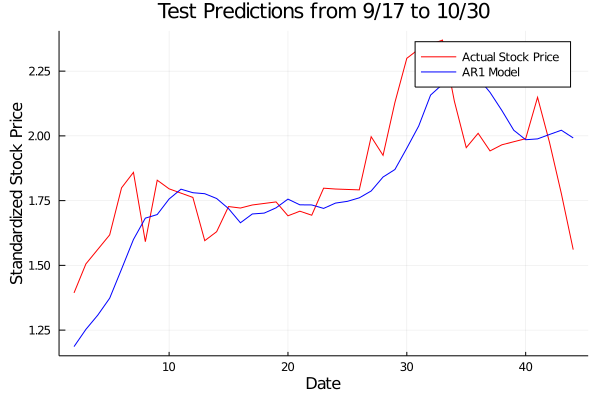

Selected Model: 18
Estimated Error: 0.28939962635971905
Validation Error: 0.10314227873090401

10×5 Array{Float64,2}:
  0.0698442    0.00431598    0.01948       0.0134315    -0.00312274
  0.630469     0.604618      0.869776      0.902384      0.956194
  0.0190353    0.0101074     0.004469      0.00266296   -0.00276144
 -0.014918    -0.000215773  -0.00941777   -0.00885687   -0.00343787
  0.0370484    0.0131561     0.000671679  -0.00428811   -0.0073569
 -0.00303242  -0.00152457   -0.00084092    0.000901983  -0.00566415
  0.0190353    0.0101074     0.004469      0.00266296   -0.00276144
  0.17737      0.101539      0.0791615     0.0587973     0.0432668
  0.0          0.0           0.0           0.0           0.0
 -0.113333    -0.25391      -0.010609     -0.00236348    0.0277793

In [8]:
# Zoom
w,mse = select_best_model_1(Zoom, sentiment, Zoom_MA)
select_best_model_2(Zoom, sentiment, w, mse, Zoom_MA)

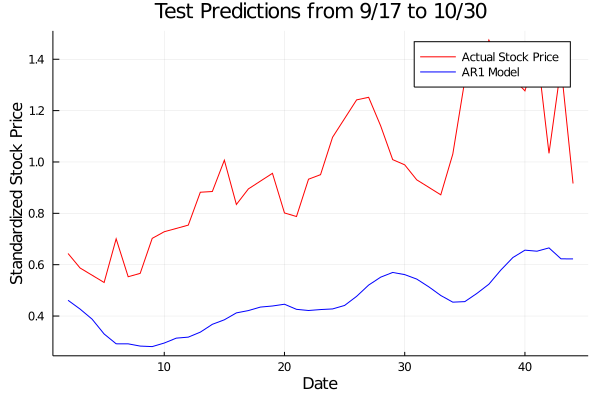

Selected Model: 10
Estimated Error: -0.6499803861887179
Validation Error: 0.22943486632418747

10×5 Array{Float64,2}:
 0.0       0.0       0.0       0.0       0.0
 0.609945  0.698981  0.553121  0.418259  0.482876
 0.0       0.0       0.0       0.0       0.0
 0.0       0.0       0.0       0.0       0.0
 0.0       0.0       0.0       0.0       0.0
 0.0       0.0       0.0       0.0       0.0
 0.0       0.0       0.0       0.0       0.0
 0.110624  0.0       0.0       0.0       0.0
 0.0       0.0       0.0       0.0       0.0
 0.0       0.0       0.0       0.0       0.0

In [9]:
# Facebook
w,mse = select_best_model_1(Facebook, sentiment, Facebook_MA)
select_best_model_2(Facebook, sentiment, w, mse, Facebook_MA)

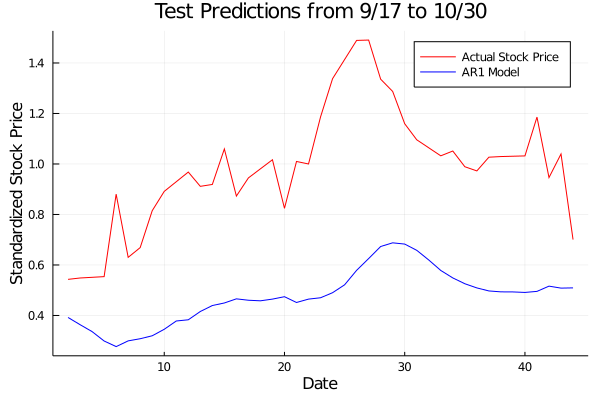

Selected Model: 10
Estimated Error: 0.2065999947000665
Validation Error: -0.016223253065845537

10×5 Array{Float64,2}:
 0.0       0.0        0.0       0.0       0.0
 0.608539  0.59888    0.528984  0.447175  0.486528
 0.0       0.0        0.0       0.0       0.0
 0.0       0.0        0.0       0.0       0.0
 0.0       0.0        0.0       0.0       0.0
 0.0       0.0        0.0       0.0       0.0
 0.0       0.0        0.0       0.0       0.0
 0.159917  0.0702165  0.0       0.0       0.0
 0.0       0.0        0.0       0.0       0.0
 0.0       0.0        0.0       0.0       0.0

In [10]:
# Amazon
w,mse = select_best_model_1(Amazon, sentiment, Amazon_MA)
select_best_model_2(Amazon, sentiment, w, mse, Amazon_MA)

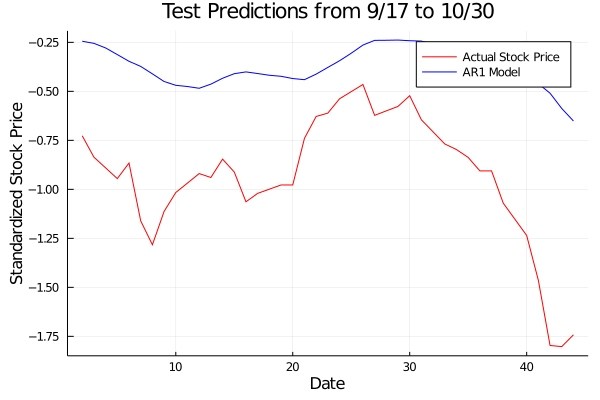

Selected Model: 10
Estimated Error: 1.0903984259392634
Validation Error: 0.5099043595237005

10×5 Array{Float64,2}:
 0.0        0.0       0.0      0.0       0.0
 0.71588    0.502707  0.45099  0.494317  0.437111
 0.0        0.0       0.0      0.0       0.0
 0.0        0.0       0.0      0.0       0.0
 0.0        0.0       0.0      0.0       0.0
 0.0        0.0       0.0      0.0       0.0
 0.0        0.0       0.0      0.0       0.0
 0.0145343  0.0       0.0      0.0       0.0
 0.0        0.0       0.0      0.0       0.0
 0.0        0.0       0.0      0.0       0.0

In [11]:
# Cisco
w,mse = select_best_model_1(Cisco, sentiment, Cisco_MA)
select_best_model_2(Cisco, sentiment, w, mse, Cisco_MA)

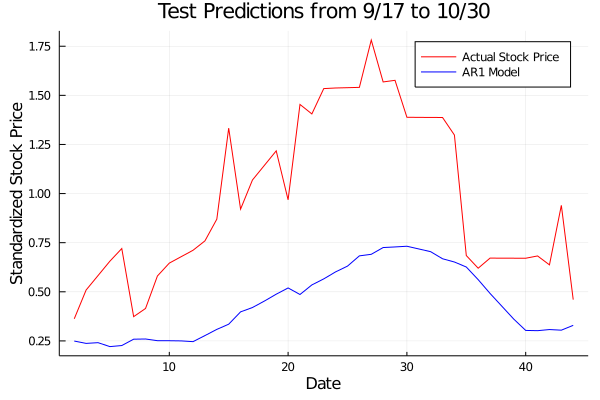

Selected Model: 10
Estimated Error: 0.1637154540084576
Validation Error: -0.0838792319170586

10×5 Array{Float64,2}:
 0.0       0.0       0.0       0.0       0.0
 0.790402  0.671625  0.529437  0.471612  0.457112
 0.0       0.0       0.0       0.0       0.0
 0.0       0.0       0.0       0.0       0.0
 0.0       0.0       0.0       0.0       0.0
 0.0       0.0       0.0       0.0       0.0
 0.0       0.0       0.0       0.0       0.0
 0.0       0.0       0.0       0.0       0.0
 0.0       0.0       0.0       0.0       0.0
 0.0       0.0       0.0       0.0       0.0

In [12]:
# Netflix
w,mse = select_best_model_1(Netflix, sentiment, Netflix_MA)
select_best_model_2(Netflix, sentiment, w, mse, Netflix_MA)

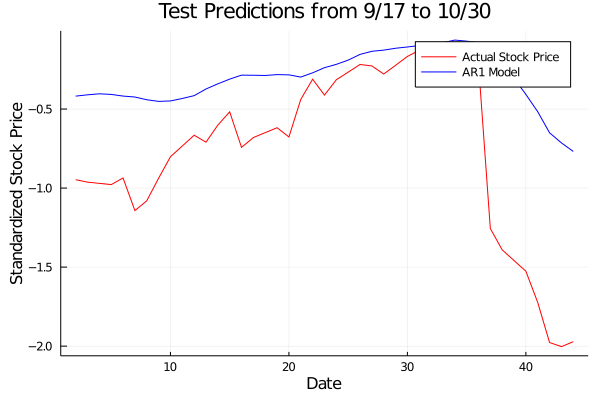

Selected Model: 10
Estimated Error: 0.5085878970415045
Validation Error: 0.5711200812317603

10×5 Array{Float64,2}:
 0.0       0.0       0.0       0.0       0.0
 0.627978  0.419825  0.467638  0.413345  0.442094
 0.0       0.0       0.0       0.0       0.0
 0.0       0.0       0.0       0.0       0.0
 0.0       0.0       0.0       0.0       0.0
 0.0       0.0       0.0       0.0       0.0
 0.0       0.0       0.0       0.0       0.0
 0.0       0.0       0.0       0.0       0.0
 0.0       0.0       0.0       0.0       0.0
 0.0       0.0       0.0       0.0       0.0

In [13]:
# Intel
w,mse = select_best_model_1(Intel, sentiment, Intel_MA)
select_best_model_2(Intel, sentiment, w, mse, Intel_MA)

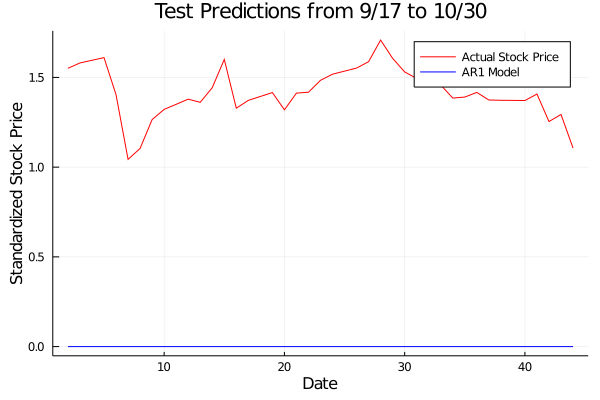

Selected Model: 11
Estimated Error: 0.4946236190143106
Validation Error: 0.03092408733086537

10×5 Array{Float64,2}:
 0.0       0.0       0.0  0.0  0.0
 0.0       0.0       0.0  0.0  0.0
 0.0       0.0       0.0  0.0  0.0
 0.0       0.0       0.0  0.0  0.0
 0.0       0.0       0.0  0.0  0.0
 0.0       0.0       0.0  0.0  0.0
 0.0       0.0       0.0  0.0  0.0
 0.198549  0.149625  0.0  0.0  0.0
 0.0       0.0       0.0  0.0  0.0
 0.0       0.0       0.0  0.0  0.0

In [14]:
# Tesla
w,mse = select_best_model_1(Tesla, sentiment, Tesla_MA)
select_best_model_2(Tesla, sentiment, w, mse, Tesla_MA)

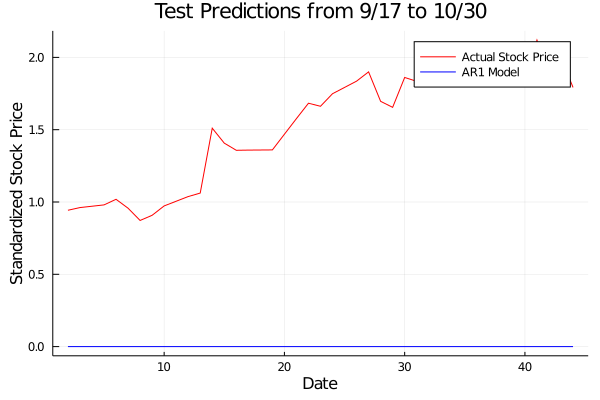

Selected Model: 12
Estimated Error: 0.5104921796469003
Validation Error: 0.02002182674233206

10×5 Array{Float64,2}:
 0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0

In [15]:
# Alibaba
w,mse = select_best_model_1(Alibaba, sentiment, Alibaba_MA)
select_best_model_2(Alibaba, sentiment, w, mse, Alibaba_MA)

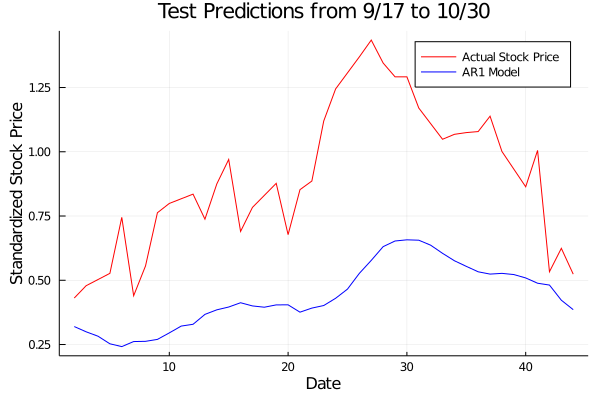

Selected Model: 1
Estimated Error: 0.17070139858938252
Validation Error: -0.17159576015758776

10×5 Array{Float64,2}:
 0.0        0.0       0.0       0.0       0.0
 0.799281   0.698463  0.559671  0.481763  0.487091
 0.0        0.0       0.0       0.0       0.0
 0.0        0.0       0.0       0.0       0.0
 0.0        0.0       0.0       0.0       0.0
 0.0        0.0       0.0       0.0       0.0
 0.0        0.0       0.0       0.0       0.0
 0.0192291  0.0       0.0       0.0       0.0
 0.0        0.0       0.0       0.0       0.0
 0.0        0.0       0.0       0.0       0.0

In [16]:
# Microsoft
w,mse = select_best_model_1(Microsoft, sentiment, Microsoft_MA)
select_best_model_2(Microsoft, sentiment, w, mse, Microsoft_MA)

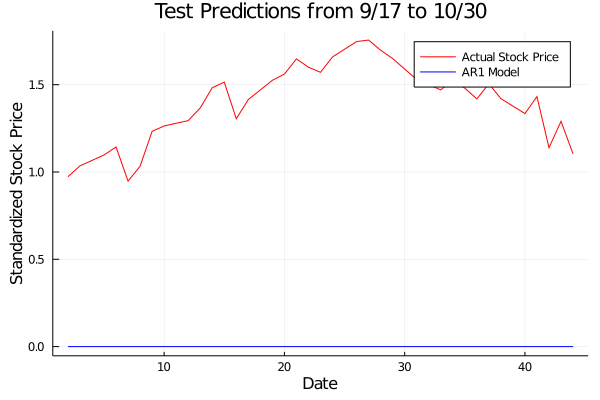

Selected Model: 17
Estimated Error: 0.26251476686750946
Validation Error: -0.11670232223283603

10×5 Array{Float64,2}:
 0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0

In [17]:
# Nvidia
w,mse = select_best_model_1(Nvidia, sentiment, Nvidia_MA)
select_best_model_2(Nvidia, sentiment, w, mse, Nvidia_MA)

In [18]:
function find_lambda_1(stock, stock_MA, fig, label1)
    i=5
    split = [43, 43+44, 43+44*2, 43+44*3, 43+44*4, 43+44*5]
    stock_train = stock[1][1:split[i]]
    splits_train = stock[2][1:split[i]]
    sent_train = sentiment[1][1:split[i]]
    death_train = sentiment[3][1:split[i]]
    vac_train = sentiment[2][1:split[i]]
    shut_train = sentiment[4][1:split[i]]
    spred_train = sentiment[5][1:split[i]]
    death_train = sentiment[6][1:split[i]]
    pos_train = sentiment[7][1:split[i]]
    stock_MA_train = stock_MA[1:split[i]-4]

    stock_test = stock[1][split[i]+1:split[i+1]]
    splits_test = stock[2][split[i]+1:split[i+1]]
    sent_test = sentiment[1][split[i]+1:split[i+1]]
    death_test = sentiment[3][split[i]+1:split[i+1]]
    vac_test = sentiment[2][split[i]+1:split[i+1]]
    shut_test = sentiment[4][split[i]+1:split[i+1]]
    spred_test = sentiment[5][split[i]+1:split[i+1]]
    death_test = sentiment[6][split[i]+1:split[i+1]]
    pos_test = sentiment[7][split[i]+1:split[i+1]]
    stock_MA_test = stock_MA[split[i]-4:split[i+1]-4]

    Xtrain = [sent_train[5:end] stock_MA_train death_train[5:end] vac_train[5:end] shut_train[5:end] spred_train[5:end] death_train[5:end] pos_train[5:end] splits_train[5:end] ones(length(sent_train[5:end]))]
    Xtest = [sent_test[5:end] stock_MA_test[6:end] death_test[5:end] vac_test[5:end] shut_test[5:end] spred_test[5:end] death_test[5:end] pos_test[5:end] splits_test[5:end] ones(length(sent_test[5:end]))]
    Ytrain = stock_train[5:end]
    Ytest = stock_test[5:end]
    # Ridge regression
    abs_er = []
    for i in [0.1:0.1:0.9;]
        n = length(Ytrain)
        loss = 1/n*QuadLoss()

        # we form λ|| ⋅ ||^2 by multiplying the QuadReg() function by λ
        λ = i
        reg = λ*QuadReg()
        w_cur = proxgrad(loss, reg, Xtrain, Ytrain, maxiters=1000)
        pred = Xtest*w_cur
        abs_er = vcat(abs_er, abs_err(Ytest,pred))
    end
    plot!([0.1:0.1:0.9;], abs_er, label = label1)
end

find_lambda_1 (generic function with 1 method)

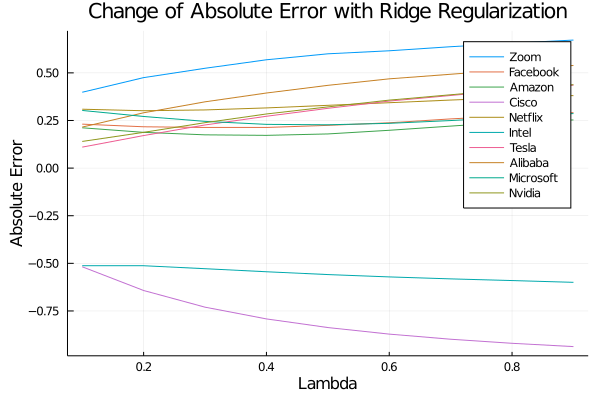

In [19]:
fig = plot(linestyle = :dot, title = "Change of Absolute Error with Ridge Regularization")
find_lambda_1(Zoom, Zoom_MA, fig, "Zoom")
find_lambda_1(Facebook, Facebook_MA, fig, "Facebook")
find_lambda_1(Amazon, Amazon_MA, fig, "Amazon")
find_lambda_1(Cisco, Cisco_MA, fig, "Cisco")
find_lambda_1(Netflix, Netflix_MA, fig, "Netflix")
find_lambda_1(Intel, Intel_MA, fig, "Intel")
find_lambda_1(Tesla, Tesla_MA, fig, "Tesla")
find_lambda_1(Alibaba, Alibaba_MA, fig, "Alibaba")
find_lambda_1(Microsoft, Microsoft_MA, fig, "Microsoft")
find_lambda_1(Nvidia, Nvidia_MA, fig, "Nvidia")
xaxis!("Lambda")
yaxis!("Absolute Error")

In [20]:
function find_lambda_2(stock, stock_MA, fig, label1)
    i=5
    split = [43, 43+44, 43+44*2, 43+44*3, 43+44*4, 43+44*5]
    stock_train = stock[1][1:split[i]]
    splits_train = stock[2][1:split[i]]
    sent_train = sentiment[1][1:split[i]]
    death_train = sentiment[3][1:split[i]]
    vac_train = sentiment[2][1:split[i]]
    shut_train = sentiment[4][1:split[i]]
    spred_train = sentiment[5][1:split[i]]
    death_train = sentiment[6][1:split[i]]
    pos_train = sentiment[7][1:split[i]]
    stock_MA_train = stock_MA[1:split[i]-4]

    stock_test = stock[1][split[i]+1:split[i+1]]
    splits_test = stock[2][split[i]+1:split[i+1]]
    sent_test = sentiment[1][split[i]+1:split[i+1]]
    death_test = sentiment[3][split[i]+1:split[i+1]]
    vac_test = sentiment[2][split[i]+1:split[i+1]]
    shut_test = sentiment[4][split[i]+1:split[i+1]]
    spred_test = sentiment[5][split[i]+1:split[i+1]]
    death_test = sentiment[6][split[i]+1:split[i+1]]
    pos_test = sentiment[7][split[i]+1:split[i+1]]
    stock_MA_test = stock_MA[split[i]-4:split[i+1]-4]

    Xtrain = [sent_train[5:end] stock_MA_train death_train[5:end] vac_train[5:end] shut_train[5:end] spred_train[5:end] death_train[5:end] pos_train[5:end] splits_train[5:end] ones(length(sent_train[5:end]))]
    Xtest = [sent_test[5:end] stock_MA_test[6:end] death_test[5:end] vac_test[5:end] shut_test[5:end] spred_test[5:end] death_test[5:end] pos_test[5:end] splits_test[5:end] ones(length(sent_test[5:end]))]
    Ytrain = stock_train[5:end]
    Ytest = stock_test[5:end]
    # Lasso regression
    abs_er = []
    for i in [0.1:0.1:0.9;]
        n = length(Ytrain)
        loss = 1/n*QuadLoss()

        # we form λ|| ⋅ ||^2 by multiplying the QuadReg() function by λ
        λ = i
        reg = λ*OneReg()
        w_cur = proxgrad(loss, reg, Xtrain, Ytrain, maxiters=1000)
        pred = Xtest*w_cur
        abs_er = vcat(abs_er, abs_err(Ytest,pred))
    end
    plot!([0.1:0.1:0.9;], abs_er, label = label1)
end

find_lambda_2 (generic function with 1 method)

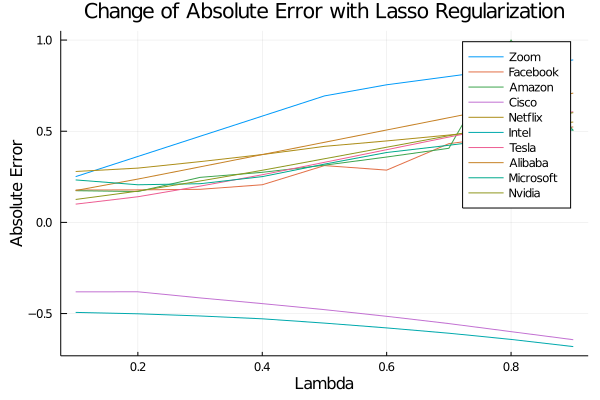

In [21]:
fig = plot(linestyle = :dot, title = "Change of Absolute Error with Lasso Regularization")
find_lambda_2(Zoom, Zoom_MA, fig, "Zoom")
find_lambda_2(Facebook, Facebook_MA, fig, "Facebook")
find_lambda_2(Amazon, Amazon_MA, fig, "Amazon")
find_lambda_2(Cisco, Cisco_MA, fig, "Cisco")
find_lambda_2(Netflix, Netflix_MA, fig, "Netflix")
find_lambda_2(Intel, Intel_MA, fig, "Intel")
find_lambda_2(Tesla, Tesla_MA, fig, "Tesla")
find_lambda_2(Alibaba, Alibaba_MA, fig, "Alibaba")
find_lambda_2(Microsoft, Microsoft_MA, fig, "Microsoft")
find_lambda_2(Nvidia, Nvidia_MA, fig, "Nvidia")
xaxis!("Lambda")
yaxis!("Absolute Error")